In [2]:
library (ROCR);
library(caret)
library(randomForest)
require(e1071)
require(pROC)

Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess

Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:dplyr’:

    combine

The following object is masked from ‘package:ggplot2’:

    margin

Loading required package: pROC
Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var



In [3]:
tab <- read.table("credit.data", dec = ".", sep=",", header = F)

In [4]:
#tab$V2 == '?'

In [5]:
dummyTab <- dummyVars("~V1 + V4 + V5 + V6 + V7 + V13", data = tab)
dummyTab <- data.frame(predict(dummyTab, newdata = tab))
dummyTab <- dummyTab[, !names(dummyTab) %in% c("V1..", "V4..", "V5..", "V6..", "V7..", "V13..")]
tab <- cbind(tab,dummyTab)
tab$V9 <- as.numeric(tab$V9)-1
tab$V10 <- as.numeric(tab$V10)-1
tab$V12 <- as.numeric(tab$V12)-1
tab$V16 <- as.numeric(tab$V16)-1
tab$V16 <- as.factor(tab$V16)
tab$V2 <- as.numeric(as.matrix(tab$V2))
tab$V14 <- as.numeric(as.matrix(tab$V14))
tab <- tab[,!names(tab) %in% c("V1", "V4", "V5", "V6", "V7", "V13")]
tab[is.na(tab)] <- 0

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

In [6]:
#tab$V2

In [7]:
auc_best = 0.0
best = c(0,0,0)
ntree = 1000
    for (mtry in c(as.integer(sqrt(43)/2), as.integer(sqrt(43)), 43)){
        for (cutoff in c(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9)){
            rfc <- randomForest(V16~., data=tab, cutoff = c(cutoff, 1-cutoff), ntree=ntree, mtry=mtry)
            recall <- rfc$confusion[4]/(rfc$confusion[3] + rfc$confusion[4])
            precision <- rfc$confusion[4]/(rfc$confusion[4] + rfc$confusion[2])
            rfc.roc <- roc(tab$V16, rfc$votes[,2])
            auc_score <- auc(rfc.roc)
            #f1_score <- 2*precision*recall/(precision + recall)
            #f1_score <- F1_Score ()
            #print(c(f1_score,"Params:", mtry, cutoff))
            if (auc_score > auc_best){
                auc_best = auc_score
                best = c(ntree,mtry,cutoff)
            }
            }
        }




In [8]:
cat(c("Best AUC_Score settings:\n","\nNtree:",best[1], "\nMtry:", best[2], "\nCutoff:", best[3],"\nAUCScore:", auc_best))

Best AUC_Score settings:
 
Ntree: 1000 
Mtry: 3 
Cutoff: 0.8 
AUCScore: 0.932591149930686

In [9]:
rfc <- randomForest(V16~., data=tab, cutoff = c(best[3], 1-best[3]), ntree=best[1], mtry=best[2])

In [10]:
#require(pROC)

Area under the curve: 0.9314

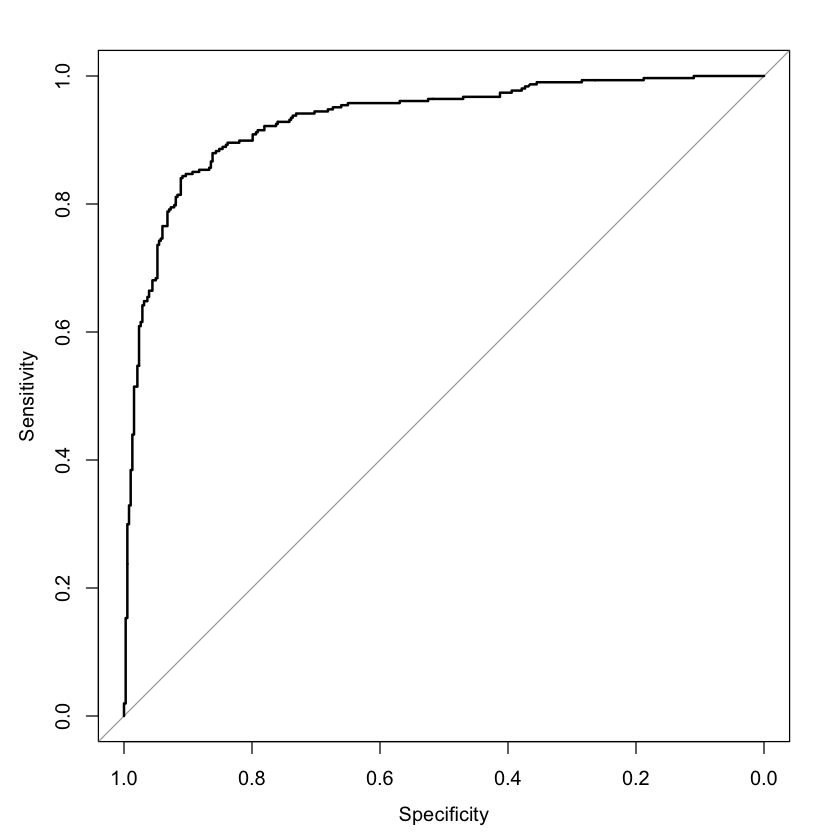

In [11]:
rfc.roc <- roc(tab$V16, rfc$votes[,2])
plot(rfc.roc)
auc(rfc.roc)

In [12]:
tab_norm <- tab
tab_norm[colnames(tab_norm) != "V16"] <- scale(tab_norm[colnames(tab_norm) != "V16"], center = TRUE, scale = FALSE)

In [13]:
n <- nrow(tab_norm)
shuffled_tab <- tab_norm[sample(n), ]
train_indices <- 1:round(0.75 * n)
train_norm <- shuffled_tab[train_indices, ]
test_indices <- (round(0.75 * n) + 1):n
test_norm <- shuffled_tab[test_indices, ]

In [14]:
F1_Score <- function (data, labels){
    
    pred <- predict(svc,data)
    recall <- table(pred, labels)[4]/(table(pred, labels)[3]+table(pred, labels)[4])
    precision <- table(pred, labels)[4]/(table(pred, labels)[4]+table(pred, labels)[2])
    f1_score <- 2*precision*recall/(precision + recall)
    f1_score
    }
AUC_Score <- function(classifier, data,labels){
    pred <- predict(classifier,data, probability = TRUE)
    pred.prob <- attr(pred, "prob")[,1]
    svc.roc <- roc(labels, pred.prob)
    #plot(svc.roc)
    auc(svc.roc)
}

In [15]:
require(e1071)
bestSvc = c(0)
auc_best_svc = 0.0
for(C in c(0.001, 0.002154435, 0.004641589, 0.01, 0.021544,0.03125,  0.06250,  0.12500,  0.25000,  0.50000,  1.00000,  2.00000,  4.00000,
8.00000, 16.00000, 32.00000)) {
    
    svc <- svm(V16~.,data=train_norm,kernel='linear',cost=C, probability = TRUE)
    
    auc_score <- AUC_Score(svc, test_norm, test_norm$V16)
    #pred <- predict(svc ,test_norm, probability = TRUE)
    #pred.prob <- attr(pred, "prob")[,1]
    #svc.roc <- roc(test_norm$V16, pred.prob)
    #plot(svc.roc)
    #auc_score <- auc(svc.roc)
    if (auc_score > auc_best_svc){
        auc_best_svc = auc_score
        bestSvc = c(C)
        cat(c("\n\nAUCScore: ",auc_best_svc, "\nC: ", C))
    }
}



AUCScore:  0.954633204633205 
C:  0.001

In [51]:
svc <- svm(V16~.,data=train_norm,kernel='linear',cost=bestSvc[1], probability = TRUE)
cat(c("Best F1_Score settings:\n", "\nC: ", bestSvc[1] ,"\n\nAUCScore: ",auc_best_svc))

Best F1_Score settings:
 
C:  0.001 

AUCScore:  0.954633204633205

In [17]:
pred <- predict(svc,test_norm, probability = TRUE)
pred.prob <- attr(pred, "prob")[,1]

Area under the curve: 0.9546

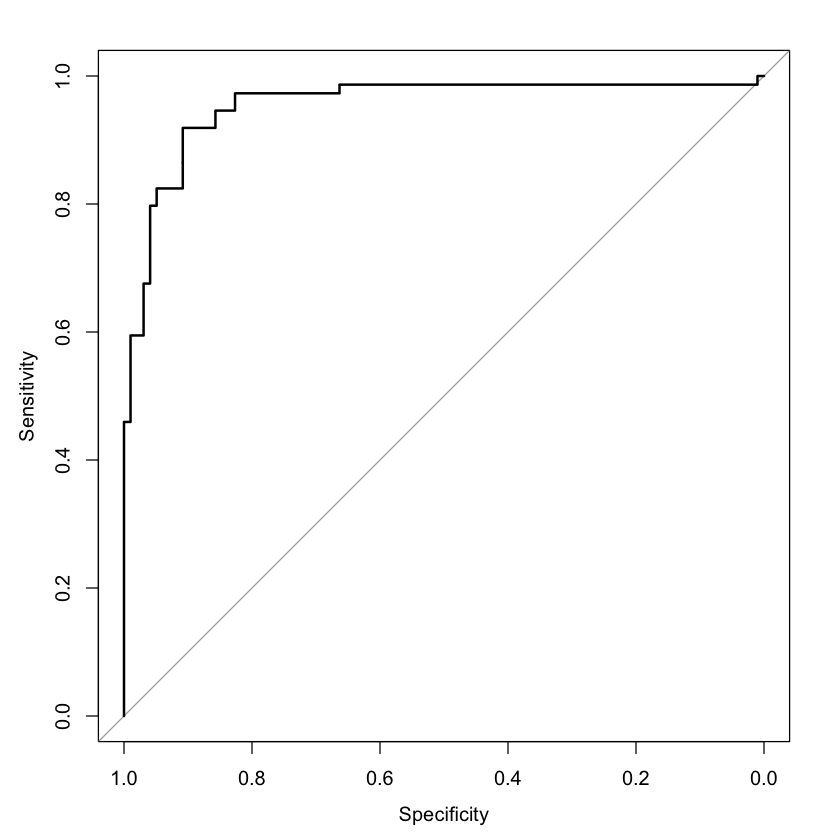

In [18]:
svc.roc <- roc(test_norm$V16, pred.prob)
plot(svc.roc)
auc(svc.roc)

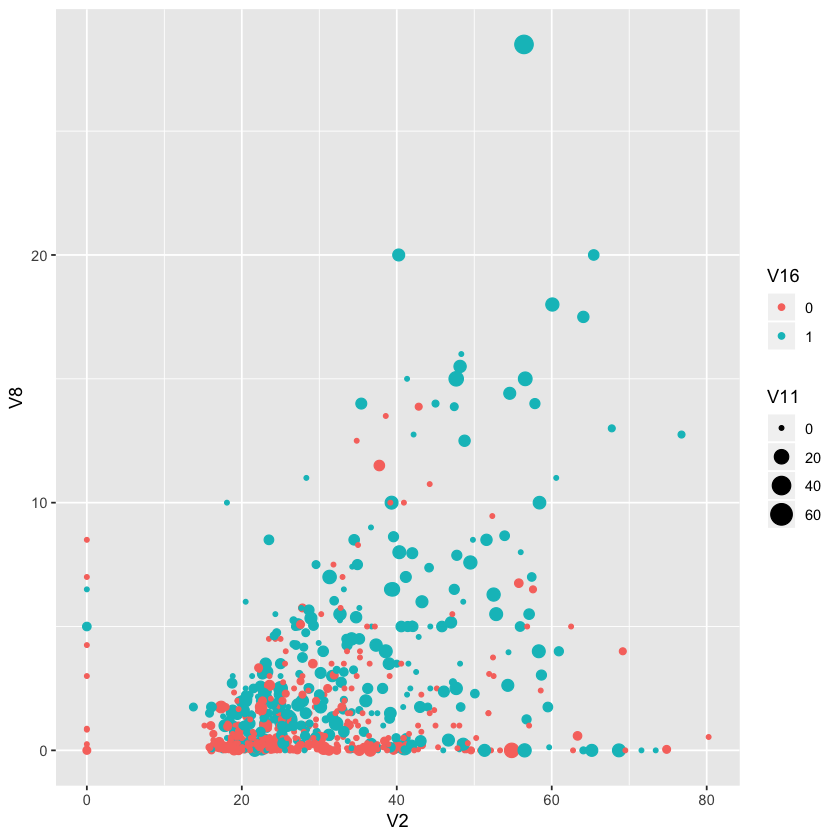

In [19]:
library(ggplot2)
ggplot(data=tab) + 
  geom_point(mapping = aes(x = V2, y = V8, color = V16, size = V11))

Warning message:
“Using size for a discrete variable is not advised.”

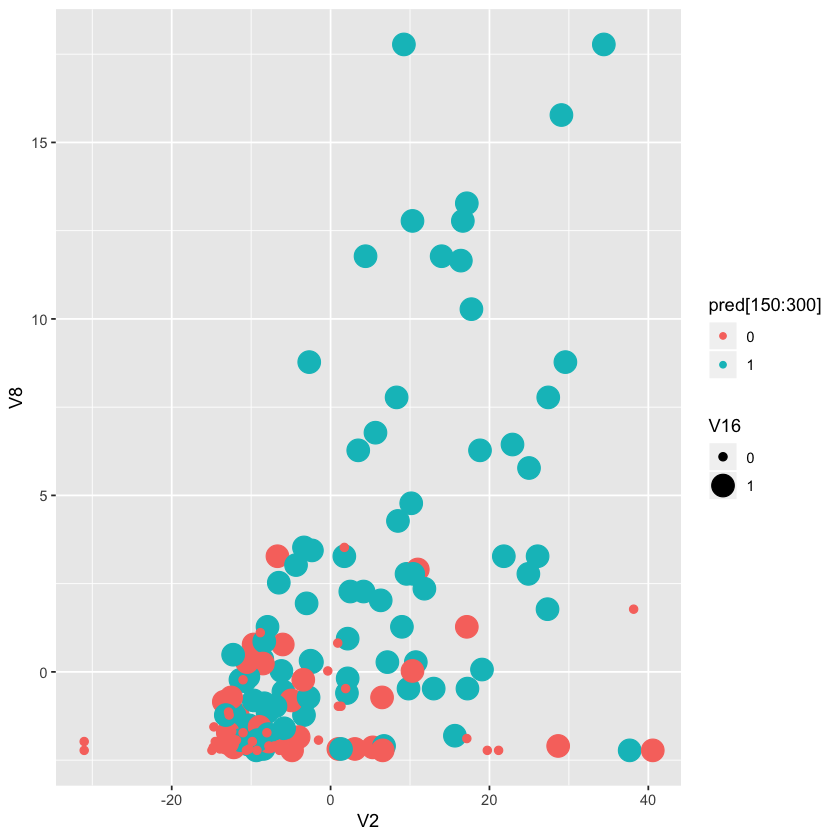

In [20]:
pred <- predict(svc, tab_norm)
ggplot(data=tab_norm[150:300,]) + 
  geom_point(mapping = aes(x = V2, y = V8, color = pred[150:300], size = V16))

Warning message:
“Using size for a discrete variable is not advised.”

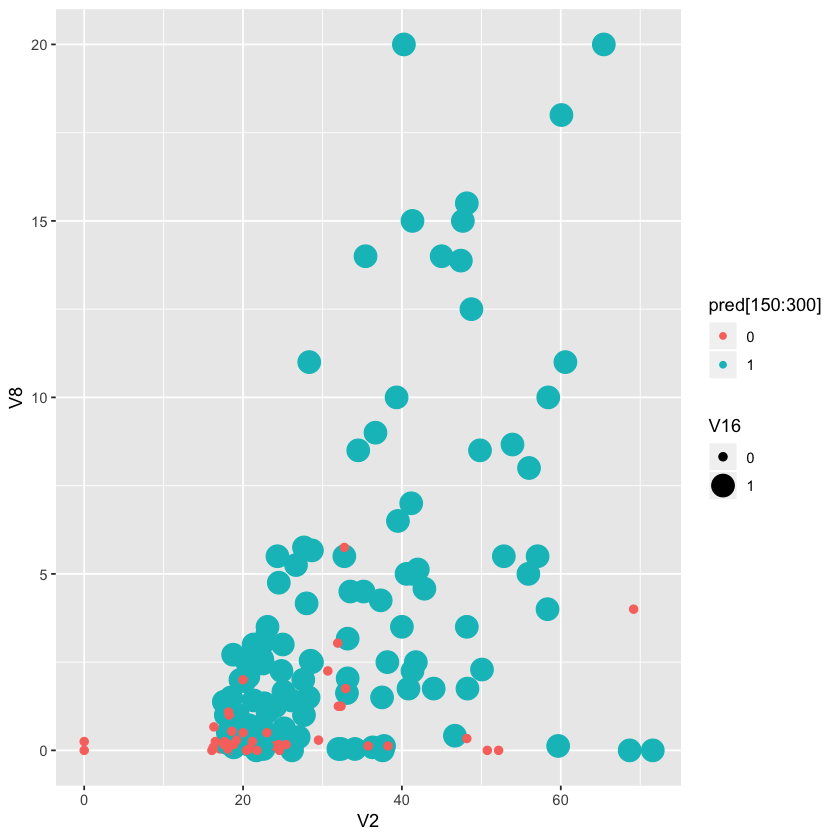

In [21]:
pred <- predict(rfc,tab, probability = TRUE)
ggplot(data=tab[150:300,]) + 
  geom_point(mapping = aes(x = V2, y = V8, color = pred[150:300], size = V16))

In [22]:
imp <- varImp(rfc)
imp <- imp[order(imp, decreasing=TRUE), , drop=FALSE]

In [23]:
w <- t(svc$coefs) %*% svc$SV
w <- abs(w)
w <- t(w)
w <- w[order(w, decreasing=TRUE), , drop=FALSE]

In [24]:
head(w, 10)

V9,0.28352351
V10,0.15934559
V11,0.13355282
V8,0.09438083
V6.x,0.06171619
V15,0.06163511
V6.q,0.05029194
V7.h,0.04754992
V6.i,0.04687920
V6.ff,0.04437524


In [25]:
head(imp, 10)

,Overall
V9,61.547279
V11,24.670648
V8,23.192566
V15,20.308522
V10,16.970511
V3,14.692815
V14,13.128649
V2,13.076607
V7.h,3.870406
V6.x,3.798900


In [26]:
new_svc <- svm(V16~.,data=train_norm[c(rownames(head(w, 10)), "V16")],kernel='linear',cost=bestSvc[1], probability = TRUE)

In [27]:
new_rfc <- randomForest(V16~., data=tab[c(rownames(head(imp, 10)), "V16")], cutoff = c(best[3], 1-best[3]), ntree=best[1], mtry=best[2])

In [28]:
    auc_score <- AUC_Score(new_svc, test_norm[rownames(head(w, 10))], test_norm$V16)
auc_score

Area under the curve: 0.9517

Area under the curve: 0.9267

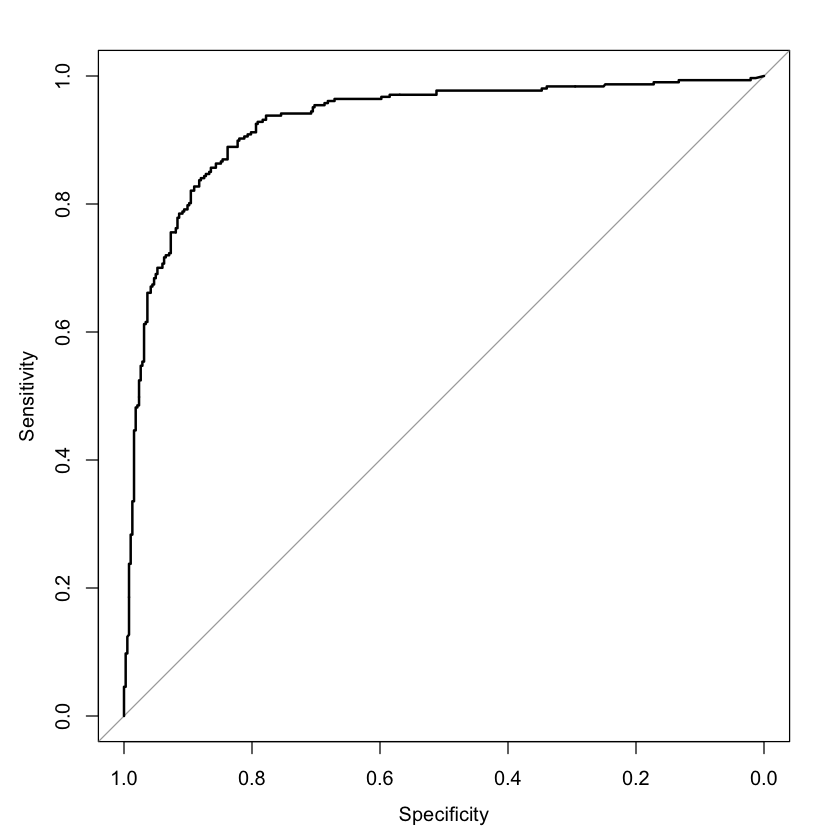

In [29]:
new_rfc.roc <- roc(tab$V16, new_rfc$votes[,2])
plot(new_rfc.roc)
auc(new_rfc.roc)

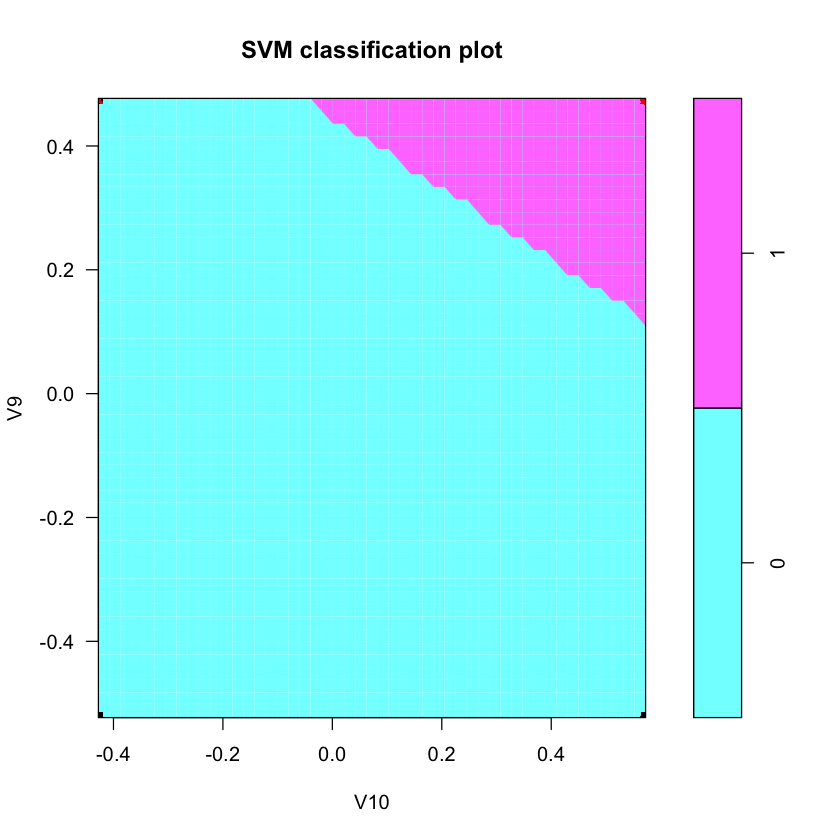

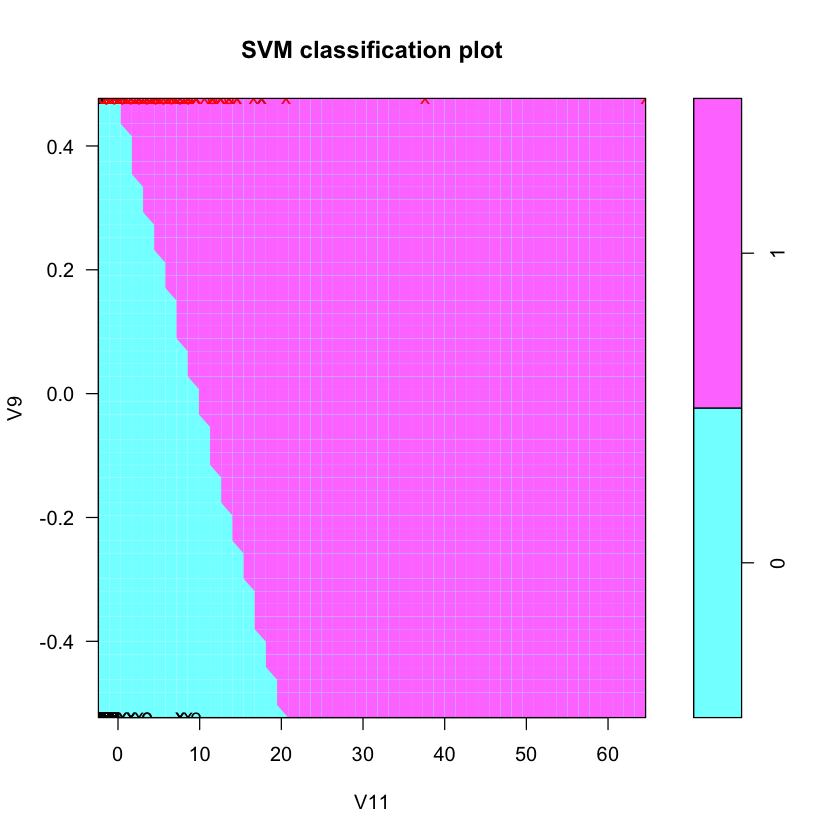

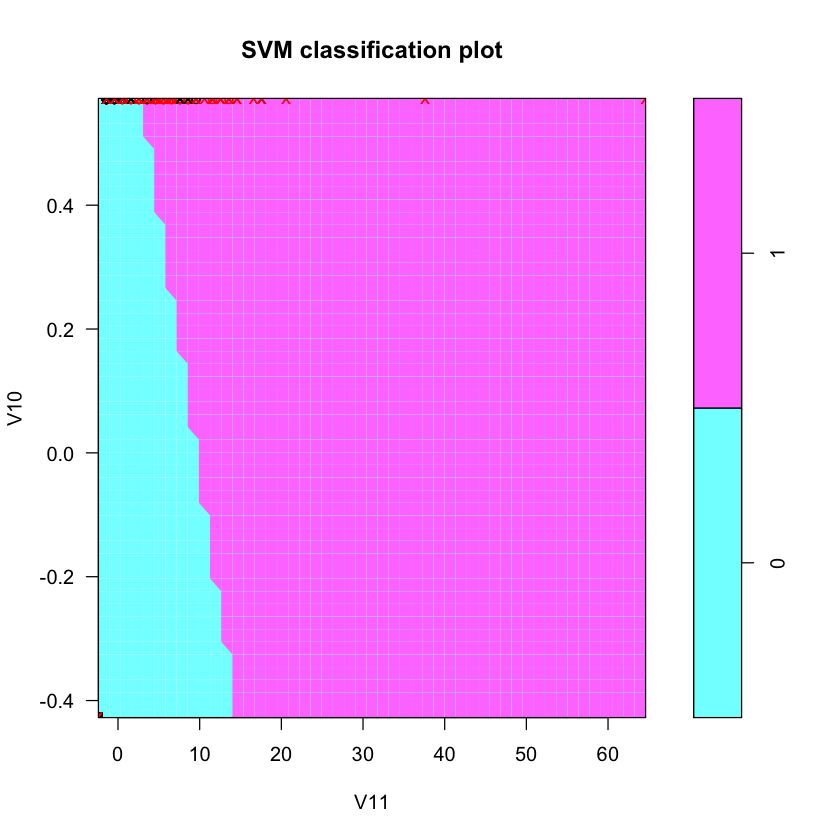

In [59]:
# Attach Packages
library(tidyverse)    # data manipulation and visualization
library(kernlab)      # SVM methodology
library(e1071)        # SVM methodology
#install.packages("ISLR")
library(ISLR)         # contains example data set "Khan"
library(RColorBrewer) # customized coloring of plots
plot(svc, data=tab_norm,V9~V10 )
plot(svc, data=tab_norm,V9~V11 )
plot(svc, data=tab_norm,V10 ~V11 )

In [45]:
test_norm

,V2,V3,V8,V9,V10,V11,V12,V14,V15,V16,⋯,V7.ff,V7.h,V7.j,V7.n,V7.o,V7.v,V7.z,V13.g,V13.p,V13.s
115,-10.3491594,-3.5087246,-0.8484058,0.4768116,0.5724638,0.6,0.542029,-40.5478261,-807.3855,0,⋯,-0.0826087,0.8,-0.0115942,-0.005797101,-0.002898551,-0.5782609,-0.0115942,0.0942029,-0.0115942,-0.0826087
224,-12.1891594,4.7812754,-2.1384058,0.4768116,-0.4275362,-2.4,-0.457971,-80.5478261,-1017.3855,1,⋯,-0.0826087,-0.2,-0.0115942,-0.005797101,-0.002898551,0.4217391,-0.0115942,0.0942029,-0.0115942,-0.0826087
489,-12.1891594,-1.2187246,-2.2234058,-0.5231884,-0.4275362,-2.4,0.542029,-0.5478261,-1016.3855,0,⋯,0.9173913,-0.2,-0.0115942,-0.005797101,-0.002898551,-0.5782609,-0.0115942,0.0942029,-0.0115942,-0.0826087
636,-12.8491594,-2.2987246,-1.2634058,-0.5231884,0.5724638,-0.4,0.542029,-20.5478261,-430.3855,0,⋯,-0.0826087,-0.2,-0.0115942,0.994202899,-0.002898551,-0.5782609,-0.0115942,0.0942029,-0.0115942,-0.0826087
146,1.8108406,-2.2587246,0.5265942,0.4768116,0.5724638,3.6,-0.457971,-20.5478261,1054.6145,1,⋯,-0.0826087,0.8,-0.0115942,-0.005797101,-0.002898551,-0.5782609,-0.0115942,0.0942029,-0.0115942,-0.0826087
428,6.4808406,-3.9237246,-2.1834058,-0.5231884,-0.4275362,-2.4,-0.457971,-60.5478261,-1012.3855,0,⋯,-0.0826087,-0.2,-0.0115942,-0.005797101,-0.002898551,0.4217391,-0.0115942,0.0942029,-0.0115942,-0.0826087
439,-3.8491594,-3.5087246,-2.2234058,-0.5231884,0.5724638,-1.4,-0.457971,-88.5478261,-717.3855,0,⋯,0.9173913,-0.2,-0.0115942,-0.005797101,-0.002898551,-0.5782609,-0.0115942,0.0942029,-0.0115942,-0.0826087
33,18.4808406,2.8262754,5.3615942,0.4768116,0.5724638,12.6,0.542029,-180.5478261,3982.6145,1,⋯,-0.0826087,-0.2,-0.0115942,-0.005797101,-0.002898551,-0.5782609,-0.0115942,0.0942029,-0.0115942,-0.0826087
603,-1.1891594,-3.5087246,-1.9734058,-0.5231884,-0.4275362,-2.4,-0.457971,43.4521739,-1017.3855,0,⋯,-0.0826087,-0.2,-0.0115942,-0.005797101,-0.002898551,0.4217391,-0.0115942,0.0942029,-0.0115942,-0.0826087
545,-0.9391594,-3.7187246,-1.7234058,0.4768116,0.5724638,7.6,0.542029,-48.5478261,-989.3855,0,⋯,-0.0826087,-0.2,-0.0115942,-0.005797101,-0.002898551,-0.5782609,-0.0115942,0.0942029,-0.0115942,-0.0826087
